In [1]:
strategy_name ='玉晶量化1号'

In [2]:
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\guanzhao\dataServer")
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
from funcs import *
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import matplotlib.dates as mdates

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang
dbt = client.tinySoftData

In [3]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1

In [9]:
startDate = 20200701
endDate = 20200712
q = list(dbt.minuteBarContinuous.find({'derivedTicker':'IC1', 'dateTimeFloat':{'$gte':startDate, '$lte':endDate}},{'dateTimeFloat':1, 'close':1, 'high':1, 'low':1}).sort('dateTimeFloat',1))
d0 = np.array([x['dateTimeFloat'] for x in q])
h0 = pd.DataFrame(np.array([x['high'] for x in q]))
l0 = pd.DataFrame(np.array([x['low'] for x in q]))
c0 = pd.DataFrame(np.array([x['close'] for x in q]))


In [10]:
def resample(close_mtx, low_mtx, high_mtx, dtes, s=3):
    d = []
    h = []
    l = []
    c = []
    for x in range(s-1,len(d0),s):
        d.append(d0[x])
        h.append(np.max(h0[0][x-s+1:x+1]))
        l.append(np.min(l0[0][x-s+1:x+1]))
        c.append(c0[0][x])
    close_mtx =  pd.DataFrame(c)
    low_mtx   =  pd.DataFrame(l)
    high_mtx  =  pd.DataFrame(h)
    dtes = np.array(d)    
    return close_mtx, low_mtx, high_mtx, dtes

close_mtx,low_mtx,high_mtx,dtes = resample(c0,l0,h0,d0,3)
c1,l1,h1,d1 = resample(c0,l0,h0,d0,60)




In [11]:
N = 3
M = 21
EMA_closeN1H = c1.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

EMA_highM1H = h1.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()
EMA_lowM1H = l1.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()

EMA_highN1H = h1.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()
EMA_lowN1H = l1.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

AMA_11H = pd.DataFrame(np.zeros(h1.shape))
AMA_21H = pd.DataFrame(np.zeros(h1.shape))

AMA_high1H = pd.DataFrame(np.zeros(h1.shape))
AMA_low1H = pd.DataFrame(np.zeros(h1.shape))

AMA1H = pd.DataFrame(np.zeros(h1.shape))

In [12]:
dif = c1.diff()
dif[0][0] = 0

for i in range(10, len(c1)):
    d  = np.abs(c1[0][i] - c1[0][i-10])
    v  = np.sum(np.abs(dif)[i-9:i+1])
    er = d/v
    sc = er*(2/3-2/31)+2/31
    ssc = sc*sc
    AMA_11H[0][i] = EMA_highM1H[0][i-1]  + ssc * (h1[0][i] - EMA_highM1H[0][i-1])
    AMA_21H[0][i] = EMA_lowM1H[0][i-1]   + ssc * (l1[0][i]  - EMA_lowM1H[0][i-1])
    #AMA_closeM[0][i] = EMA_closeM[0][i] + ssc * (close_mtx[0][i] - EMA_closeM[0][i])
    AMA_high1H[0][i] = EMA_highN1H[0][i-1] + ssc * (h1[0][i] - EMA_highN1H[0][i-1])
    AMA_low1H[0][i] = EMA_lowN1H[0][i-1] + ssc * (l1[0][i] - EMA_lowN1H[0][i-1])
    AMA1H[0][i] = (AMA_high1H[0][i]+AMA_low1H[0][i])/2
    print(d1[i],AMA1H[0][i], AMA_11H[0][i],AMA_21H[0][i])


20200703.14 5982.301242984984 5919.887645964998 5870.637307590289
20200703.15 5992.896607654924 5937.04312136127 5885.17964134261
20200706.103 6058.378651676361 6034.329035223403 5944.46690718745
20200706.113 6141.98097837448 6074.106204455034 5998.700630839771
20200706.14 6218.938279824781 6115.315268750553 6032.946404904666
20200706.15 6273.08557048492 6136.228630052378 6061.035767167122
20200707.103 6341.2943898888625 6225.792386436769 6123.2654117998345
20200707.113 6392.816618582952 6239.213626584852 6168.621927203778
20200707.14 6432.79943274596 6273.269695674722 6200.8991517588165
20200707.15 6442.324662285038 6226.76433677165 6145.003661361659
20200708.103 6435.445971141818 6252.460916470424 6171.907091960026
20200708.113 6434.605779251215 6281.7668169436 6203.113662699542
20200708.14 6449.989567829536 6287.548070523696 6214.592740949973
20200708.15 6470.463350173921 6307.276421607034 6234.350594424252
20200709.103 6506.3053465320145 6356.0477484051125 6272.064416447516
2020070

In [13]:
N = 3
M = 15
EMA_closeN = close_mtx.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

EMA_highM = high_mtx.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()
EMA_lowM  =  low_mtx.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()

EMA_highN = high_mtx.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()
EMA_lowN  =  low_mtx.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

AMA_1 = pd.DataFrame(np.zeros(high_mtx.shape))
AMA_2 = pd.DataFrame(np.zeros(high_mtx.shape))

AMA_high = pd.DataFrame(np.zeros(high_mtx.shape))
AMA_low = pd.DataFrame(np.zeros(high_mtx.shape))

AMA   = pd.DataFrame(np.zeros(high_mtx.shape))

In [14]:
#第一步：计算效率比ER（Efficiency Ratio）
#ER = 变化值/波动值变化值 = 当前价格与N周期前价格差值的绝对值
dif = close_mtx.diff()
dif[0][0] = 0
constant = 1

for i in range(10, len(close_mtx)):
    d  = np.abs(close_mtx[0][i] - close_mtx[0][i-10])
    v  = np.sum(np.abs(dif)[i-9:i+1])
    er = d/v
    sc = er*(2/3-2/31)+2/31
    ssc = sc*sc
    AMA_1[0][i] = EMA_highM[0][i-1]  + ssc * (high_mtx[0][i] - EMA_highM[0][i-1])
    AMA_2[0][i] = EMA_lowM[0][i-1]   + ssc * (low_mtx[0][i]  - EMA_lowM[0][i-1])
    #AMA_closeM[0][i] = EMA_closeM[0][i] + ssc * (close_mtx[0][i] - EMA_closeM[0][i])
    AMA_high[0][i] = EMA_highN[0][i-1] + ssc * (high_mtx[0][i] - EMA_highN[0][i-1])
    AMA_low[0][i] = EMA_lowN[0][i-1] + ssc * (low_mtx[0][i] - EMA_lowN[0][i-1])
    AMA[0][i] = (AMA_high[0][i]+AMA_low[0][i])/2
    print(dtes[i],AMA[0][i], AMA_1[0][i],AMA_2[0][i])


20200701.1003 5809.979449222814 5821.1223043885775 5808.2476906493885
20200701.1006 5809.219073393684 5819.961775401202 5808.002727421349
20200701.1009 5810.612221598957 5819.448182121697 5808.073584441639
20200701.1012 5811.800041260616 5818.866869374375 5808.381397721437
20200701.1015 5811.91118744571 5818.293833665375 5808.554952167554
20200701.1018 5810.614454845687 5817.478780327449 5808.37059172066
20200701.1021 5809.992178134387 5816.57280836077 5807.9686044257405
20200701.1024 5806.588492582845 5815.704007789873 5806.9230149806945
20200701.1027 5805.540507527425 5815.22955016163 5805.812794979251
20200701.103 5810.066728836873 5815.7352936365205 5806.4487122231185
20200701.1033 5813.641286303404 5816.491128336117 5807.46284050085
20200701.1036 5815.631322186968 5817.1088270228 5808.012835401788
20200701.1039 5817.573066706609 5817.821573593604 5809.059681017659
20200701.1042 5817.099672514138 5818.088537200847 5809.416732663695
20200701.1045 5814.208049992831 5817.887264561617 

20200702.1336 5901.920531490115 5911.307725850817 5901.347757025962
20200702.1339 5901.457839536641 5910.436678854567 5900.639829761172
20200702.1342 5898.459370996919 5909.1872062602315 5899.479405658192
20200702.1345 5897.603166212 5908.545629165045 5898.244910137083
20200702.1348 5899.172270536719 5907.820375363637 5897.890378574328
20200702.1351 5899.236766620643 5907.529858160651 5897.748193003388
20200702.1354 5901.538282486772 5907.6654228919 5897.950802723691
20200702.1357 5904.155223481363 5907.787550118577 5898.578819044099
20200702.14 5902.290676738523 5907.66549280286 5898.158788719728
20200702.1403 5899.241148895442 5907.118087387241 5897.081834634543
20200702.1406 5901.523607011255 5907.615062295258 5897.503665329069
20200702.1409 5907.052941397148 5909.340433575866 5899.434537739995
20200702.1412 5909.675118608835 5909.712399395282 5899.839126365803
20200702.1415 5911.436216111002 5910.65064033185 5901.0618049819695
20200702.1418 5912.69612203455 5913.8452747933325 5902.

20200706.1057 6243.9251684886285 6233.3264016885 6215.6616225119005
20200706.11 6241.530016563707 6235.055895810226 6218.718812941247
20200706.1103 6239.6498466465855 6236.1657367394655 6220.311359329775
20200706.1106 6238.078680934066 6237.387665611713 6221.207895032969
20200706.1109 6238.09301854688 6238.19412338731 6222.001312086519
20200706.1112 6240.178491545195 6239.536830169172 6224.057450339631
20200706.1115 6243.587212792983 6241.394837058438 6225.553252421561
20200706.1118 6247.268663221967 6244.279431972049 6228.828184313734
20200706.1121 6252.616241426023 6248.397904869162 6232.665857407171
20200706.1124 6257.813829055399 6250.8164008410795 6235.312909380682
20200706.1127 6264.577826067874 6259.358359976547 6241.69340927053
20200706.113 6274.133780555439 6264.831459124839 6248.876041787122
20200706.1303 6286.8233710057375 6277.968945299172 6257.821333515182
20200706.1306 6298.889492156527 6285.8813386665515 6267.723706126158
20200706.1309 6314.8635260716055 6301.73783667353

20200708.1054 6456.477628586148 6450.374190911172 6436.644019184709
20200708.1057 6458.653622745578 6451.81279564439 6438.778511942684
20200708.11 6461.489778513767 6456.9205550941115 6442.879015884789
20200708.1103 6464.964674618273 6456.9078562860295 6443.813318317468
20200708.1106 6468.163626210797 6459.643273397591 6446.333966960549
20200708.1109 6471.307736913619 6464.212697296816 6450.167668558021
20200708.1112 6478.1424820105185 6468.886015936862 6455.467784393304
20200708.1115 6485.196517670578 6470.886149315171 6457.81754825258
20200708.1118 6488.612704956828 6472.012994108125 6458.678726467893
20200708.1121 6485.699930878284 6473.993299440632 6459.970209578553
20200708.1124 6477.992743667588 6475.033331727828 6460.745840178109
20200708.1127 6479.027296291879 6476.541737279434 6462.626887054433
20200708.113 6481.527828213961 6477.565961932929 6464.071818836124
20200708.1303 6481.508003371777 6478.699214321889 6465.827326923438
20200708.1306 6480.327320495265 6479.597555111051 

20200709.1445 6652.280146935576 6669.096854071924 6646.024190037597
20200709.1448 6665.581681940495 6671.190870342645 6649.991684119489
20200709.1451 6673.0008614142225 6672.912132508543 6652.9981115339315
20200709.1454 6677.673559672978 6675.418923054814 6656.908495511953
20200709.1457 6681.576403772107 6678.485330267578 6661.673075364843
20200709.15 6692.436901669615 6694.130118790124 6673.4896927979125
20200710.0933 6691.337602774407 6685.530723647937 6665.558537815579
20200710.0936 6689.891712226297 6689.352386150042 6671.023868040928
20200710.0939 6696.190763097222 6693.414503215602 6674.539964370285
20200710.0942 6702.7060433605875 6694.589233791739 6674.858927567208
20200710.0945 6709.942069256519 6700.141081710471 6678.685715967797
20200710.0948 6713.5804423364825 6708.621951052273 6684.4678755380955
20200710.0951 6726.042188472922 6715.608566264772 6694.0806286765155
20200710.0954 6739.91788974568 6721.43047546492 6699.9923666459035
20200710.0957 6747.005466599301 6725.6192430

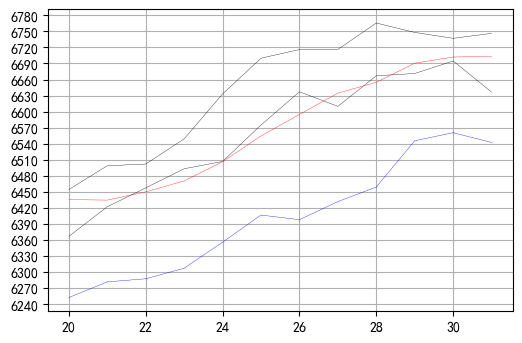

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
plt.figure()
st = 20
et = len(d1)
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(h1[0][st:et],'k',linewidth=0.25)
plt.plot(l1[0][st:et],'k',linewidth=0.25)
plt.plot(AMA_11H[0][st:et],'b.-',linewidth=0.25, markersize=0.1)
#plt.plot(AMA_21H[0][st:et],'b',linewidth=0.25)
plt.plot(AMA1H[0][st:et],'r',linewidth=0.25)
plt.grid()
y_major_locator=MultipleLocator(30)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.yaxis.set_major_locator(y_major_locator)
#把x轴的主刻度设置为1的倍数


In [16]:
# 将一小时的AMA上轨线 up sample至3分钟上，作为判断依据
AMA_hourH = np.zeros(dtes.shape)
AMA_hourL = np.zeros(dtes.shape)
for (i,x) in enumerate(d1):
    if i<len(d1)-1:
        idx = (dtes>=d1[i]) & (dtes<d1[i+1])
        AMA_hourH[idx] = AMA_11H[0][i]
        AMA_hourL[idx] = AMA_21H[0][i]
    else:
        idx = dtes>=d1[i]
        AMA_hourH[idx] = AMA_11H[0][i]
        AMA_hourL[idx] = AMA_21H[0][i]
        

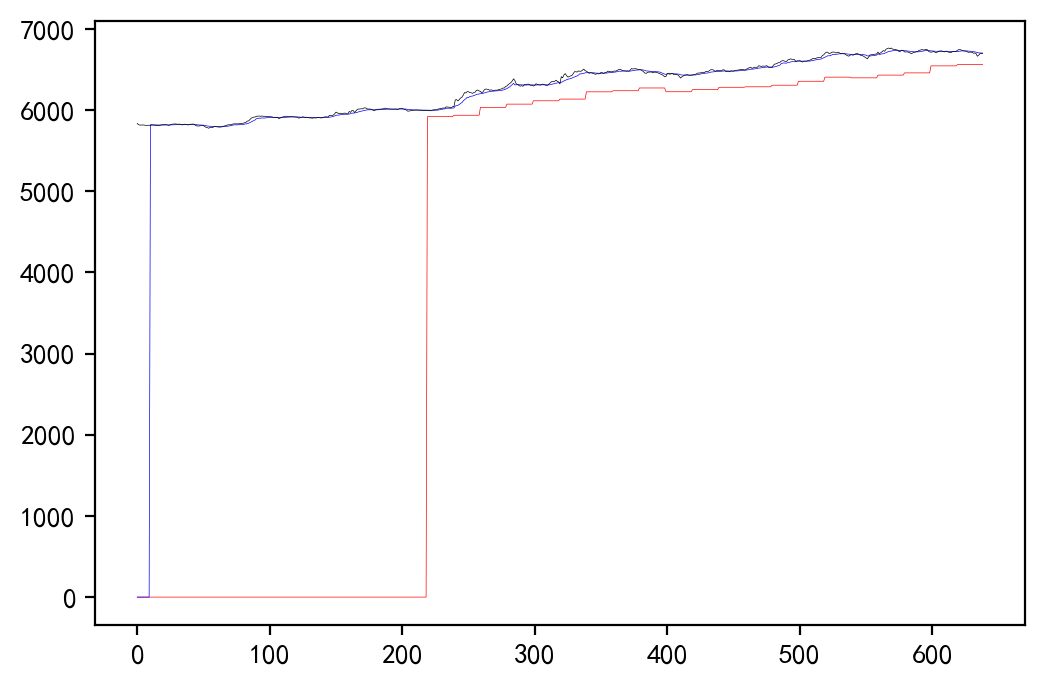

In [20]:
plt.plot(AMA_hourH[:-1],'r-',lineWidth=0.25)
plt.plot(np.array(AMA_1[0][:-1]),'b-', lineWidth=0.25)
plt.plot(np.array(high_mtx[0][:-1]),'k-', lineWidth=0.25)

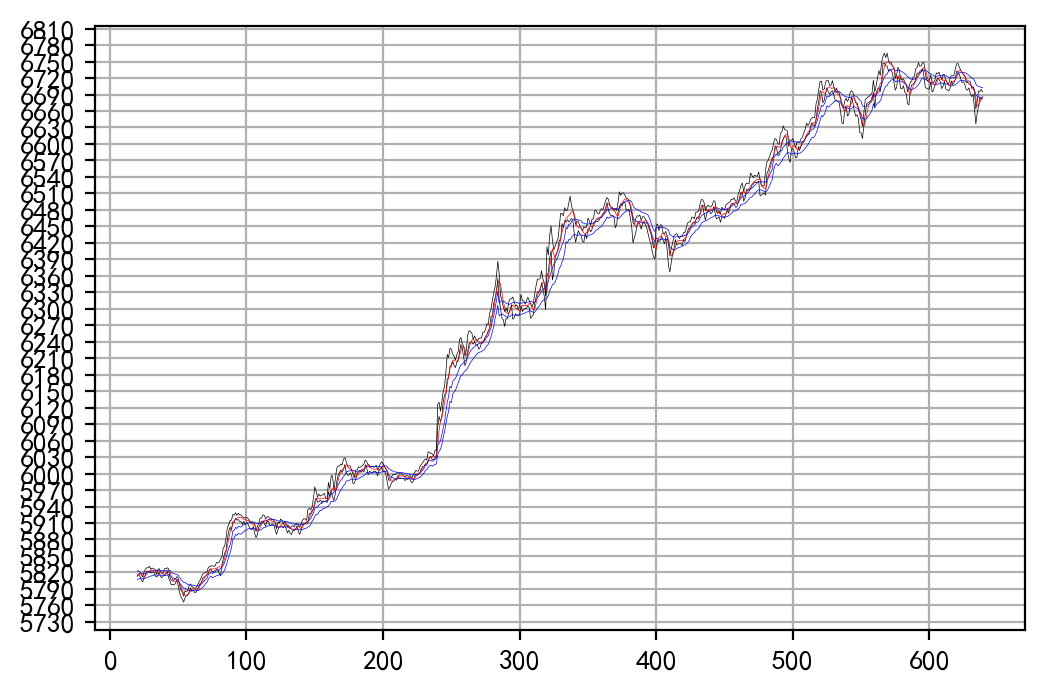

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
plt.figure()
st = 20
et = len(dtes)
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(high_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(low_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(AMA_1[0][st:et],'b',linewidth=0.25)
plt.plot(AMA_2[0][st:et],'b',linewidth=0.25)
plt.plot(AMA[0][st:et],'r',linewidth=0.25)
plt.grid()
y_major_locator=MultipleLocator(30)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.yaxis.set_major_locator(y_major_locator)
#把x轴的主刻度设置为1的倍数


In [22]:
# 做空
sellInPrice = -1
atrW = 30
atrH = 30
atrS = 30
status = 'idle'
pnl = []
pnlShort = np.zeros(AMA_1.shape)
dtesPnl = []
AmlifyLine = 0 # 增加突破难度
for i in range(len(AMA[0])):
    if (AMA[0][i]<(AMA_2[0][i]+AmlifyLine)) & (status=='idle') & (high_mtx[0][i]<=AMA_hourL[i]):
#    if (AMA[0][i]<(AMA_2[0][i]+AmlifyLine))&(status=='idle'):
        sellInPrice = low_mtx[0][i]+atrH # 如果AMA<下轨， 且处于空闲状态， 则进入等待状态，且做空价=当前K线最低价+ATRH
        status='wait'
        print(dtes[i], 'AMA破下轨, 前低设定为:',low_mtx[0][i], ' 买入点设定为:',sellInPrice)#,' AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
    if (status=='wait'): 
        if (high_mtx[0][i]>=sellInPrice): # 如果处于等待状态，且当前K线最高价格高于做空价，则做空
            status='short'
            print(dtes[i], '到达卖出点:',sellInPrice)#, 'AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
        if (low_mtx[0][i]+atrH)<sellInPrice: # 如果处于等待状态，还没有做空，且创新低，则更新做空价=当前最低价+ATRH
            sellInPrice=low_mtx[0][i]+atrH
            print(dtes[i], '创新低:',low_mtx[0][i],' 更新做空价:',sellInPrice)#', AMA=',AMA[0][i], ', AMA1=',AMA_1[0][i])
    if (status=='short'):
        if (high_mtx[0][i]>=sellInPrice+atrS): # 最高价高于卖出价+ATRS，说明止损
            profit = -atrS
            pnl.append(profit)
            pnlShort[i] = profit
            print(dtes[i],'到达止损点:',sellInPrice+atrS)
            dtesPnl.append(dtes[i])
            status='idle'
        if (low_mtx[0][i]<=sellInPrice-atrW+1): # 最低价低于卖出价-ATRW， 说明止盈
            profit = atrW-1
            pnl.append(profit)
            pnlShort[i] = profit
            dtesPnl.append(dtes[i])
            print(dtes[i],'到达止赢点:',sellInPrice-atrW+1)
            status='idle'
            
        
        

In [23]:
# 做多
buyInPrice = -1
atrW = 30
atrH = 30
atrS = 30
status = 'idle'
pnl = []
pnlLong = np.zeros(AMA_1.shape)
dtesPnl = []
AmlifyLine = 0 # 增加突破难度
for i in range(len(AMA[0])):
    if (AMA[0][i]>(AMA_1[0][i]+AmlifyLine))&(status=='idle')&(low_mtx[0][i]>=AMA_hourH[i]):
#    if (AMA[0][i]>(AMA_1[0][i]+AmlifyLine))&(status=='idle'):
        buyInPrice = high_mtx[0][i]-atrH # 如果AMA>上轨， 且处于空闲状态， 则进入等待状态，且买入价=当前K线最高价-ATRH
        status='wait'
        print(dtes[i], 'AMA破上轨, 前高设定为:',high_mtx[0][i], ' 买入点设定为:',buyInPrice)#,' AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
    if (status=='wait'): 
        if (low_mtx[0][i]<=buyInPrice): # 如果处于等待状态，且当前K线最低价格低于买入价，则买入
            status='long'
            print(dtes[i], '到达买入点:',buyInPrice)#, 'AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
        if (high_mtx[0][i]-atrH)>buyInPrice: # 如果处于等待状态，还没有买入，且创新高，则更新买入价=当前最高价-ATRH
            buyInPrice=high_mtx[0][i]-atrH
            print(dtes[i], '创新高:',high_mtx[0][i],' 更新买入价:',buyInPrice)#', AMA=',AMA[0][i], ', AMA1=',AMA_1[0][i])
    if (status=='long'):
        if (low_mtx[0][i]<=buyInPrice-atrS): # 最低价小于买入价-ATRS，说明止损
            profit = -atrS
            pnl.append(profit)
            pnlLong[i] = profit
            print(dtes[i],'到达止损点:',buyInPrice-atrS)
            dtesPnl.append(dtes[i])
            status='idle'
        if (high_mtx[0][i]>=buyInPrice+atrW-1): # 最高价高于买入价+ATRW， 说明止盈
            profit = atrW-1
            pnl.append(profit)
            pnlLong[i] = profit
            dtesPnl.append(dtes[i])
            print(dtes[i],'到达止赢点:',buyInPrice+atrW-1)
            status='idle'
            
        
        

20200701.1057 AMA破上轨, 前高设定为: 5828.4  买入点设定为: 5798.4
20200701.11 创新高: 5831.2  更新买入价: 5801.2
20200701.1318 到达买入点: 5801.2
20200701.1342 到达止损点: 5771.2
20200701.1424 AMA破上轨, 前高设定为: 5811.6  买入点设定为: 5781.6
20200701.1427 创新高: 5817.0  更新买入价: 5787.0
20200701.143 创新高: 5818.6  更新买入价: 5788.6
20200701.1433 创新高: 5820.4  更新买入价: 5790.4
20200701.1439 创新高: 5828.8  更新买入价: 5798.8
20200701.1442 创新高: 5831.0  更新买入价: 5801.0
20200701.1445 创新高: 5831.4  更新买入价: 5801.4
20200701.1448 创新高: 5832.0  更新买入价: 5802.0
20200701.1457 创新高: 5838.0  更新买入价: 5808.0
20200702.0933 创新高: 5838.8  更新买入价: 5808.8
20200702.0936 创新高: 5844.6  更新买入价: 5814.6
20200702.0939 创新高: 5847.6  更新买入价: 5817.6
20200702.0942 创新高: 5864.8  更新买入价: 5834.8
20200702.0945 创新高: 5867.6  更新买入价: 5837.6
20200702.0948 创新高: 5882.6  更新买入价: 5852.6
20200702.0951 创新高: 5901.0  更新买入价: 5871.0
20200702.0954 创新高: 5907.4  更新买入价: 5877.4
20200702.0957 创新高: 5914.6  更新买入价: 5884.6
20200702.1 创新高: 5915.0  更新买入价: 5885.0
20200702.1003 创新高: 5925.6  更新买入价: 5895.6
20200702.1009 创新高: 5928.6 

In [ ]:
plt.plot(np.cumsum(pnlLong),'r')
plt.plot(np.cumsum(pnlShort), 'b')
plt.plot(np.cumsum(pnlLong+pnlShort),'k')
plt.grid()
plt.legend(['多','空','多+空'])
plt.title('多+空')

In [ ]:
#for (i,x) in enumerate(dtesPnl):
#    print(x, pnl[i])
plt.figure()
st = 20
et = len(dtes)
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(high_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(low_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(AMA_1[0][st:et],'b',linewidth=0.25)
plt.plot(AMA_2[0][st:et],'b',linewidth=0.25)
plt.plot(AMA[0][st:et],'r',linewidth=0.25)
plt.grid()
def dtes2Label(dtes):
    return np.array([datetime.strptime(str(int(np.floor(d))), '%Y%m%d').date() for d in dtes])
plt.figure()
plt.plot(np.cumsum(pnl2),'b.-')
#plt.plot(np.cumsum(pnl),'b-')
plt.gcf().autofmt_xdate()  # 自动旋转日期标记
plt.grid()

In [18]:
AMA_hour[AMA_hour==0]= AMA_hour[1000]
AMA_1[0][AMA_1[0]==0]=AMA_1[0][1000]
AMA_hourL[AMA_hourL==0]= AMA_hourL[1000]
AMA_2[0][AMA_2[0]==0]=AMA_2[0][1000]


NameError: name 'AMA_hour' is not defined

In [19]:
pnl2=pnl2.flatten()

NameError: name 'pnl2' is not defined

In [293]:
idx1 = np.nonzero(pnl2>0)[0]
idx2 = np.nonzero(pnl2<0)[0]
k = np.array(range(len(pnl2)))


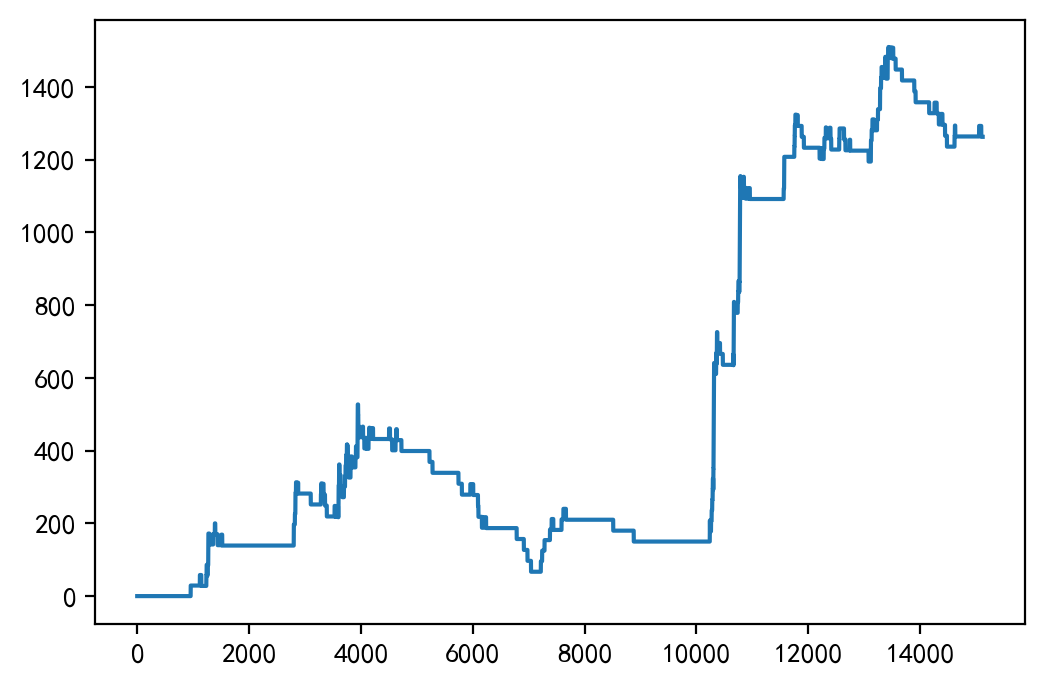

In [294]:
plt.plot(np.cumsum(pnl2))

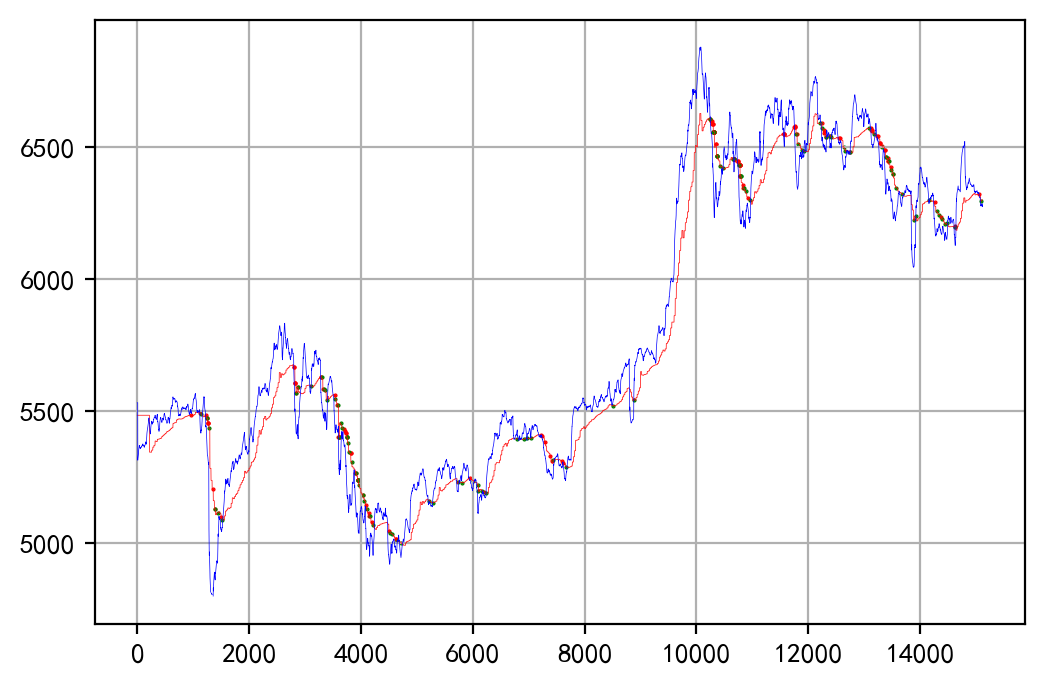

In [295]:
plt.plot(AMA_hourL,'r-', lineWidth=0.25)
plt.plot(np.array(AMA_2[0]),'b-', lineWidth=0.25)
plt.scatter(k[idx1], AMA_hourL[idx1],s=0.25,c='red')
plt.scatter(k[idx2], AMA_hourL[idx2],s=0.25,c='green')
plt.grid()

In [296]:
dtes

array([20200102.093300, 20200102.093600, 20200102.093900, ...,
       20201016.145400, 20201016.145700, 20201016.150000])